In [3]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=False
DATADIR = "/DATA" if in_container else "/BEE/Connectome/ABCD/"
raw_data_path = "/ASD2/ahsan_projects/datasets/MSLUB/"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/msseg/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [6]:
%ls -ailh $processed_data_path | head

total 91M
27944621129 drwxr-xr-x.  2 amahmood res 4.0K Nov 19 16:09 ./
 8659475441 drwxrwxrwx. 32 amahmood res 4.0K Nov 19 10:56 ../
27945370519 -rw-r--r--.  1 amahmood res  29K Nov 19 14:52 MSSEGCase01_label.nii.gz
27945370501 -rw-r--r--.  1 amahmood res  11M Nov 19 14:52 MSSEGCase01.nii.gz
27945370527 -rw-r--r--.  1 amahmood res  31K Nov 19 15:01 MSSEGCase02_label.nii.gz
27945370502 -rw-r--r--.  1 amahmood res 9.0M Nov 19 15:00 MSSEGCase02.nii.gz
27945370528 -rw-r--r--.  1 amahmood res  29K Nov 19 15:09 MSSEGCase03_label.nii.gz
27945370503 -rw-r--r--.  1 amahmood res 8.4M Nov 19 15:09 MSSEGCase03.nii.gz
27945370529 -rw-r--r--.  1 amahmood res  30K Nov 19 15:18 MSSEGCase04_label.nii.gz


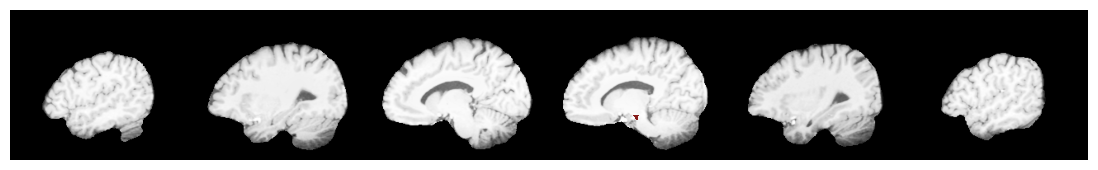

In [7]:
img, _ = ants.image_read(
    f"{processed_data_path}/MSSEGCase01.nii.gz"
).split_channels()
seg = ants.image_read(f"{processed_data_path}/MSSEGCase01_label.nii.gz")
img.plot(nslices=6, overlay=seg)

### WM Segmentations fail, so we can use simple heuristics

In [8]:
img_paths = glob.glob(f"{processed_data_path}/MSSEG*[0-9].nii.gz")
subids = [re.search(r"(MSSEG.*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(10,
 '//BEE/Connectome/ABCD//Users/amahmood/braintyp/msseg/MSSEGCase01.nii.gz',
 'MSSEGCase01')

In [9]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

CPU times: user 6.97 s, sys: 174 ms, total: 7.14 s
Wall time: 7.68 s


In [10]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

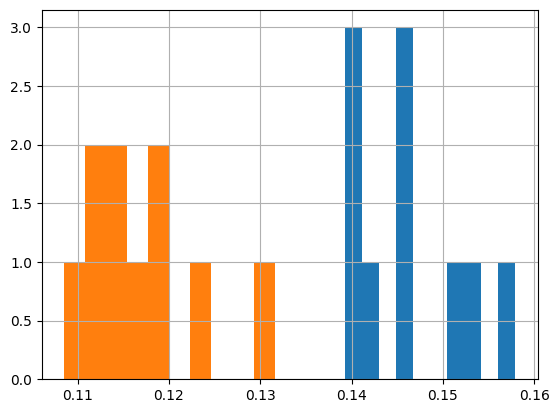

In [11]:
t1_wm_means.hist()
t2_wm_means.hist()

In [12]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

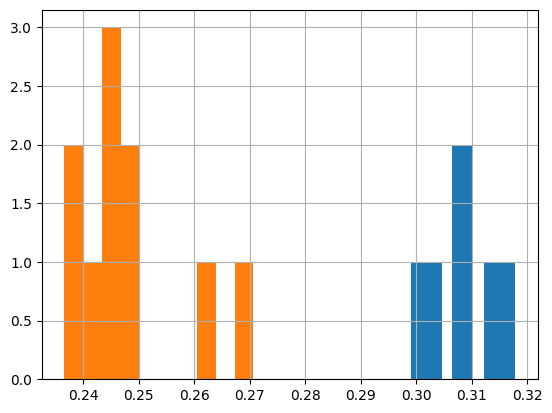

In [13]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [14]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.146 w/ std 0.006


In [15]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.308 w/ std 0.006


In [16]:
mult = 3
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

0

In [17]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

10

In [18]:
for tidx in t1_outliers[:4]:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [19]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [20]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.117 w/ std 0.007


In [21]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.248 w/ std 0.011


In [24]:
mult = 3
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

0

In [25]:
for tidx in t2_outliers[:4]:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

In [26]:
t1_drop_samples = t1_wm_means.index[t1_outliers].to_list()
t2_drop_samples = t2_wm_means.index[t2_outliers].to_list()
drop_samples = set(t1_drop_samples).union(set(t2_drop_samples))
len(drop_samples)

0

In [27]:
len(t1_wm_means)

10

In [28]:
keep_samples = t1_wm_means.drop(index=drop_samples).index.to_list()
len(keep_samples)

10

In [29]:
brats_gli_passing_keys = pd.Series(keep_samples)
brats_gli_passing_keys.to_csv('../split-keys/msseg_keys.txt', header=None, index=None)